# Solving for the risk with Cifar10 data

## Define plot parameters

In [1]:
import matplotlib.font_manager as fm
import matplotlib.ft2font as ft
import matplotlib

import matplotlib.font_manager as fm
import matplotlib.ft2font as ft
import matplotlib

from matplotlib import rc
import seaborn as sns




sns.set_style('ticks')
sns.set_context('paper', font_scale=2.25)
fig_dict = {
    'figsize':[8.0, 6.0],
}
math_dict = {
    'fontset': 'cm',
}
legend_dict = {
    'fontsize': 20,
    'markerscale': 2.7,
}
savefig_dict = {
    'bbox': 'tight',
    'transparent': 'True',
    'pad_inches': 0.1,
}
axes_dict = {
    'titlesize': '20',
    'titlepad': '5.5',
    'labelsize': '25',
    'labelpad': '7',
    'formatter.use_mathtext' : 'True'
}
lines_dict = {
    'linewidth': 2.7,
}

rc('figure', **fig_dict)
rc('mathtext', **math_dict)
rc('legend', **legend_dict)
rc('savefig', **savefig_dict)
rc('axes', **axes_dict)
rc('lines', **lines_dict)

from matplotlib.font_manager import FontProperties

f_name = '/Users/ruth/Helvetica/helvetica_regular.ttf'
fm.fontManager.addfont(f_name)
font = ft.FT2Font(f_name)

custom_font = FontProperties(fname= f_name)

matplotlib.rcParams['font.sans-serif'].insert(0, font.family_name)
matplotlib.rcParams['font.family'] = font.family_name

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import scipy

from sgd_methods import one_pass_sgd, one_pass_sign_sgd, vanilla_ode, sign_ode, one_pass_clipped_sgd, clipped_ode
from reduction_factors import mu_GAU, nu_GAU

## Load the cifar10 data

In [3]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Initialize lists to hold the data and labels
data = []
labels = []

# Loop through the DataLoader
for inputs, target in tqdm(trainset):
    data.append(inputs)
    labels.append(target)

# Convert to tensors if needed
data = torch.stack(data)
targets = torch.tensor(labels)
data = data.flatten(start_dim = 1)
data = data - data.mean(dim = 0)


# We'll just subset for two classes
class1 = [2,3,5]
class2 = [9,8,0]

data = data[np.isin(targets,class1) | np.isin(targets,class2),:]
targets = targets[np.isin(targets,class1) | np.isin(targets,class2)]



targets[np.isin(targets,class1)] = -1.
targets[np.isin(targets,class2)] = 1.
# targets[targets>=4] = -1.
# targets[targets<4] = 1.

data = data.numpy()
targets = targets.numpy()


n = data.shape[0]
ambient_d = data.shape[1]

# print(f'Classes: {classes[class1]} vs. {classes[class2]}')
print("Data:", data.shape)
print("targets:", targets.shape)

Files already downloaded and verified


  0%|          | 0/50000 [00:00<?, ?it/s]

Data: (30000, 3072)
targets: (30000,)


In [4]:
# Estimate the covariance
ambient_d = 500
rf_mat = np.random.randn(data.shape[1], ambient_d)
# data = np.maximum(data @ rf_mat, 0)
data = np.tanh(data @ rf_mat)

data = data - np.mean(data, axis=0) # Should be mean 0 already, doesn't hurt
K = data.T @ data / n

op_norm = norm(K, ord = 2)
data = data / np.sqrt(op_norm)
K = K / op_norm
op_norm = 1.

# ambient_d = K.shape[0]
print(op_norm)

# ambient_d = K.shape[0]
d = np.trace(K) / op_norm
print(f'Intrinsic dimension: {d}')

1.0
Intrinsic dimension: 5.684111697449229


In [5]:
## First we need to find a good optimal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression(fit_intercept=False)
model.fit(data, targets)

y_pred = model.predict(data)
mse = mean_squared_error(y_pred, targets)
print(f'Sklearn gives MSE: {mse}')

num_runs = 50

Sklearn gives MSE: 0.5681066030966775


In [6]:
x_star = model.coef_

# For signSGD x0 and x_star should be pretty close together
x0 = x_star + np.random.randn(ambient_d) * 0.4

# Also need the std of the error
err = targets - y_pred
noise_std = np.std(err)
print(f'Estimated error std: {np.sqrt(noise_std)}')
print(f'Distance to optimal : {norm(x0 -x_star)}')
print(f'Acc: {np.sum(np.sign(y_pred) == targets) / n}')

Estimated error std: 0.8681753669333998
Distance to optimal : 8.874011646879392
Acc: 0.8088666666666666


In [7]:
from scipy import stats
import scipy
tpdf = stats.t.pdf

df = 3 # Cauchy data from student-t family
scale = 0.5
eps = stats.t.rvs(df, size=n, scale = scale)

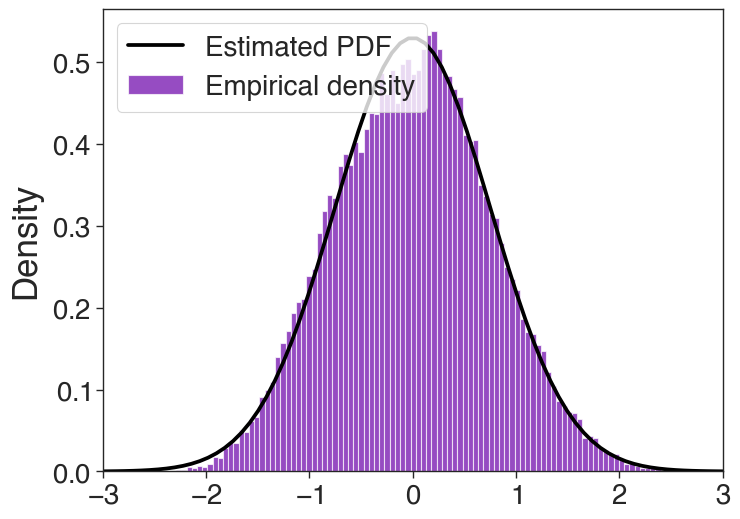

In [13]:
#Initialize lists to store the results
T = n / d
d = np.trace(K)
lr = 0.1
c = 0.5


m = 4
x = np.linspace(-m,m,100)
gau = np.exp(-x**2 / 2 / noise_std**2) / np.sqrt(2 * np.pi * noise_std**2)

tpdf_values = stats.t.pdf(x, df, scale=scale)

cmap = 'plasma'
hist_col = plt.get_cmap(cmap)(0.2)
plt.hist(err, density=True, bins= 100, alpha = 0.7, color = hist_col)
plt.xlim([-3,3])

plt.ylabel('Density')
plt.plot(x,gau, color = 'black')
name = f'cifar10_num_runs_{num_runs}_random_feat_intdim{d:.3f}_lr_{lr}_gau_noise_class1_{class1}_class2_{class2}.pdf'
plt.legend(['Estimated PDF', 'Empirical density'])
plt.savefig('noise_hist' + name, format = 'pdf')
# plt.plot(x,tpdf_values)
plt.show()

In [9]:
# d = 50
lrk = lr / d
ck = c * np.sqrt(d)

sgd_risk_list = []
sgd_time_list = []
clipped_sgd_risk_list = []
clipped_sgd_time_list = []

for _ in range(num_runs):
    # Shuffle data and targets together
    shuffled_indices = np.random.permutation(len(data))
    data_shuffled = data[shuffled_indices]
    targets_shuffled = targets[shuffled_indices]
    
    # Run one pass of SGD and clipped SGD
    sgd_risk, sgd_time = one_pass_sgd(K, data_shuffled, targets_shuffled, x0, x_star, lrk)
    clipped_sgd_risk, clipped_sgd_time = one_pass_clipped_sgd(K, data_shuffled, targets_shuffled, x0, x_star, lrk, ck)
    
    # Save results
    sgd_risk_list.append(sgd_risk)
    sgd_time_list.append(sgd_time)
    clipped_sgd_risk_list.append(clipped_sgd_risk)
    clipped_sgd_time_list.append(clipped_sgd_time)

# Convert results to arrays (optional)
sgd_risk_array = np.array(sgd_risk_list)
sgd_time_array = np.array(sgd_time_list)
clipped_sgd_risk_array = np.array(clipped_sgd_risk_list)
clipped_sgd_time_array = np.array(clipped_sgd_time_list)

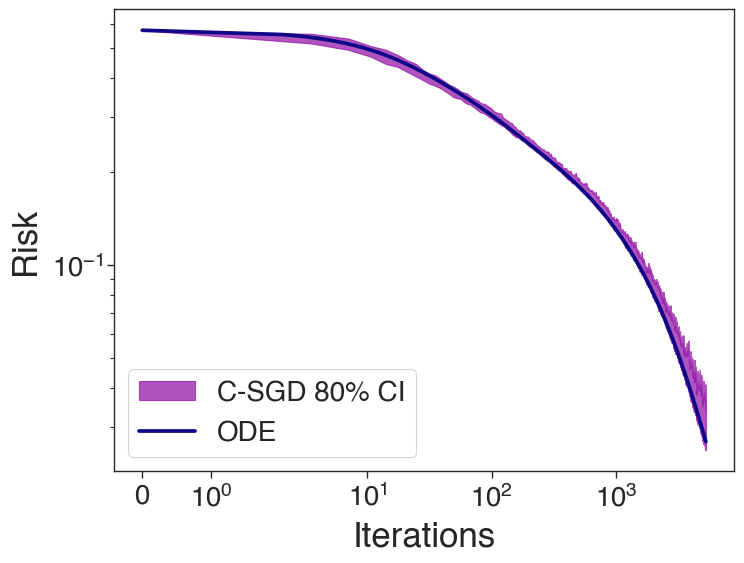

In [10]:
# Set confidence level
confidence = 0.8
q_low = (1 - confidence) / 2
q_high = 1/2 + confidence/2

# Compute quantiles for confidence interval
sgd_low = np.quantile(sgd_risk_array, q_low, axis=0)
sgd_high = np.quantile(sgd_risk_array, q_high, axis=0)

clipped_sgd_low = np.quantile(clipped_sgd_risk_array, q_low, axis=0)
clipped_sgd_high = np.quantile(clipped_sgd_risk_array, q_high, axis=0)

# Compute the ODEs
mu_nu_args = {'eta': noise_std, 'c': c}
ode_risk, ode_time = vanilla_ode(K,T, noise_std, x0, x_star, lr)
clipped_ode_risk, ode_time,_,_ = clipped_ode(K,T, x0, x_star, lr, mu_GAU, nu_GAU, mu_nu_args)



# Set the colormap and colors
cmap = 'plasma'
unc_sgd_color = plt.get_cmap(cmap)(0.66)
clipped_sgd_color = plt.get_cmap(cmap)(0.3)
ode_color = plt.get_cmap(cmap)(1)


##### Plotting
# plt.fill_between(sgd_time / d, sgd_low, sgd_high, color=unc_sgd_color, alpha=0.7, label='SGD 80% CI')
plt.fill_between(clipped_sgd_time / d, clipped_sgd_low, clipped_sgd_high, color=clipped_sgd_color, alpha=0.7, label='C-SGD 80% CI')

# Plot the means
# plt.plot(sgd_time / d, np.mean(sgd_risk_array, axis=0), color=sgd_color, label='SGD Mean')
# plt.plot(clipped_sgd_time / d, np.mean(clipped_sgd_risk_array, axis=0), color=clipped_sgd_color, label='Clipped SGD Mean')

# Plot ODE results
plt.plot(ode_time, clipped_ode_risk, color=ode_color, label='ODE')

plt.xscale('symlog')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Risk')
plt.legend()
# plt.grid(True)

plt.savefig('sgd_runs' + name, format = 'pdf')

plt.show()

In [11]:
name

'cifar10_num_runs_50_random_feat_intdim5.684_lr_0.1_gau_noise_class1_[2, 3, 5]_class2_[9, 8, 0].pdf'